# Import the required libraries

In [26]:
import tensorflow as tf
import pathlib
from tqdm import tqdm
import numpy as np
import pandas as pd

# Download the original model to colab instance

In [2]:
!wget --no-check-certificate --no-clobber https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/Deeppicar-ori.hdf5

File ‘Deeppicar-ori.hdf5’ already there; not retrieving.



In [3]:
mkdir models/

In [4]:
mv ./Deeppicar-ori.hdf5 ./models/

# Load TFLite model and allocate tensors.

In [5]:
# Config
model_path = "./models/Deeppicar-ori.hdf5"

In [6]:
DEEPPICAR_MODEL = tf.keras.models.load_model(model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(DEEPPICAR_MODEL)

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)
# This will report back the file size in bytes

INFO:tensorflow:Assets written to: /tmp/tmp_spz4v5m/assets


1016148

In [7]:
tflite_model_file = '/tmp/model1.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

# Evaluate the model

## We need to get the X_test, y_test (same code from Training.ipynb)


In [27]:
!gdown https://drive.google.com/uc?id=1TLz4J4qP3ppLLeOFtmddbkIxkeLzVnaU
train_image = np.load("./preprocess_data.npy")
train_image.shape
!wget --no-check-certificate --no-clobber https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/preprocess_path.csv
train_df = pd.read_csv("./preprocess_path.csv")
train_df.head()
X = np.array(train_image)
y = train_df['wheel'] 

Downloading...
From: https://drive.google.com/uc?id=1TLz4J4qP3ppLLeOFtmddbkIxkeLzVnaU
To: /content/preprocess_data.npy
1.74GB [00:16, 104MB/s] 
File ‘preprocess_path.csv’ already there; not retrieving.



## Split the dataset to 60% train, 20% validation, 20% test

<font color='red'>WARNING</font><br/>
**IF YOU CHANGE THE ``random_state`` IN THIS NOTEBOOK (Inferencing.ipynb), REMEMBER TO CHANGE Training.ipynb NOTEBOOK TOO! <br/>**
<font color='blue'>NOTE</font><br/>
We cannot send or transfer variables other than saving it to pkl file which will be troublesome. **PLEASE KEEP THE ``random_state`` in both notebook to ensure same data splits**

In [16]:
def split_stratified_into_train_val_test(X, y,frac_train, frac_val, frac_test,
                                          random_state=7):
  if frac_train + frac_val + frac_test != 1.0:
      raise ValueError(f"Train {frac_train} + val {frac_val} + test {frac_test} doesnt add up to 1!")
  X_train, X_temp, y_train, y_temp = train_test_split(X,y,stratify=y,test_size=(1.0 - frac_train),random_state=random_state)
  remaining_frac = frac_test / (frac_val + frac_test)
  X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,test_size=remaining_frac,random_state=random_state)
  assert y.shape[0] == len(X_train) + len(X_val) + len(X_test)
  return X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
from sklearn.model_selection import train_test_split
X_train, y_train,X_val, y_val, X_test, y_test = split_stratified_into_train_val_test(X,y,0.6,0.2,0.2)

In [35]:
predictions = []
test_labels, test_imgs = [], []

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

length = len(X_val)
for i in tqdm(range(length)):
  img = X_val[i]
  img = np.expand_dims(img, axis=0).astype(np.float32)
  test_imgs.append(img)

  interpreter.set_tensor(input_index, img)
  # Run inference.
  interpreter.invoke()
  # Post-processing: remove batch dimension and find the digit with highest probability.
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(y_val.iloc[i])

100%|██████████| 2200/2200 [00:15<00:00, 141.88it/s]


In [39]:
import matplotlib.pylab as plt
class_names = {
  0.0:  'center',
  -0.52359878: 'left', 
  0.52359878: 'right'
}

def plot_image(i, predictions_array, true_label, img, accuracy):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  # IMPORTANT: To prevent 0.5235987755979999 key error
  true_label = round(true_label, 8)
  
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  
  if predicted_label == true_label:
    color = 'green'
    accuracy += 1
  else:
    color = 'red'
  
  plt.xlabel(f"{class_names[predicted_label]} {100*np.max(predictions_array):.2f}%  Actual:{class_names[true_label]}"
  , color=color)

  return accuracy

# Visualisation

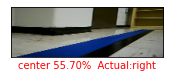

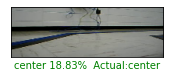

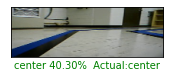

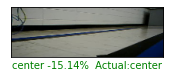

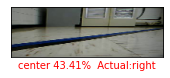

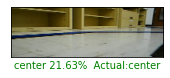

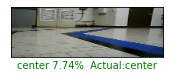

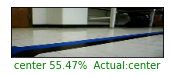

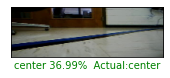

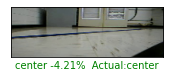

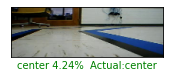

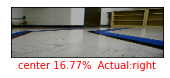

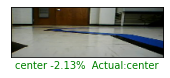

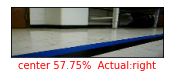

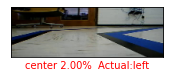

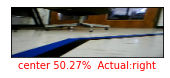

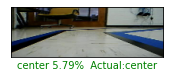

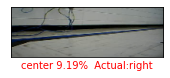

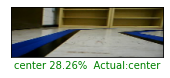

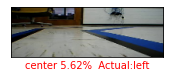

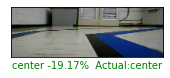

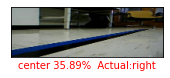

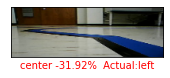

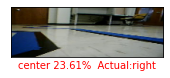

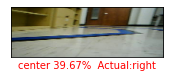

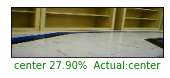

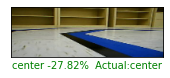

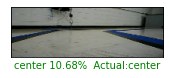

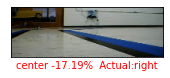

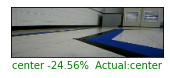

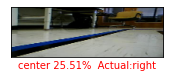

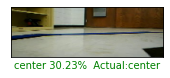

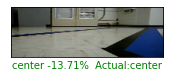

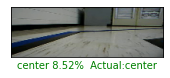

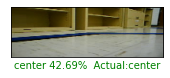

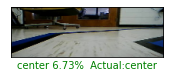

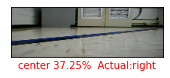

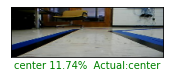

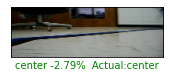

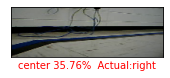

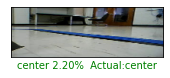

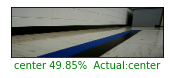

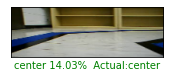

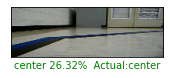

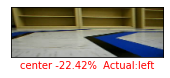

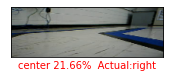

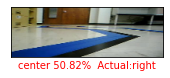

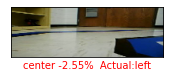

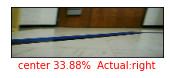

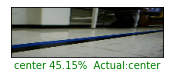

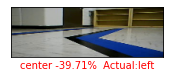

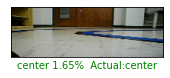

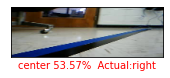

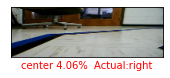

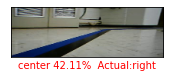

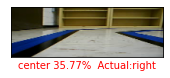

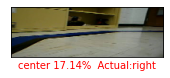

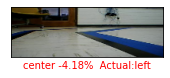

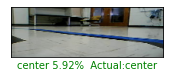

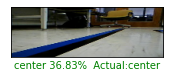

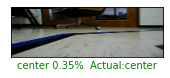

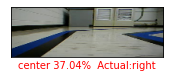

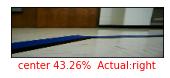

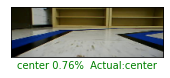

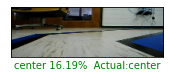

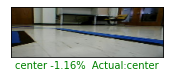

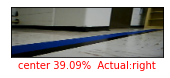

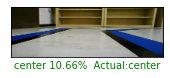

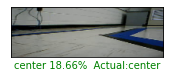

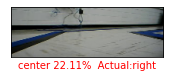

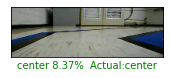

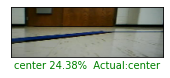

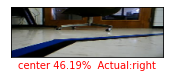

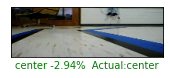

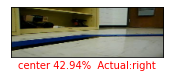

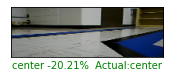

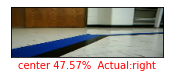

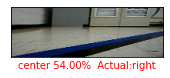

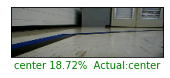

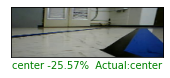

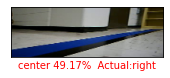

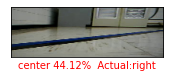

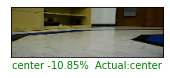

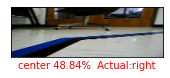

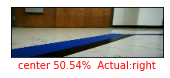

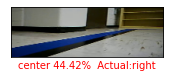

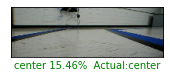

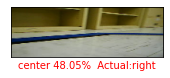

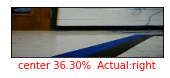

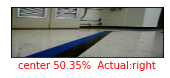

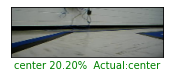

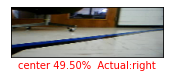

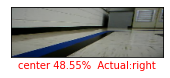

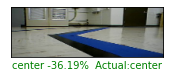

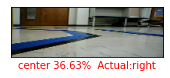

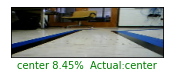

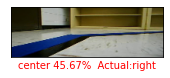

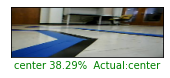

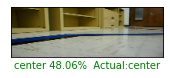

In [40]:
#@title Visualize the outputs { run: "auto" }
index = 22 #@param {type:"slider", min:0, max:99, step:1}
accuracy = 0
for index in range(0,99):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  accuracy = plot_image(index, predictions, test_labels, test_imgs, accuracy)
  plt.show()

In [41]:
print(f"Accuracy is {(accuracy/100)*100}%")

Accuracy is 51.0


## Visualize the network

In [44]:
# from matplotlib import pyplot

# successive_outputs = [layer.output for layer in model.layers[1:]]
# layer_names = [layer.name for layer in model.layers]

# visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# feature_maps = visualization_model.predict(X_val[0])

# square = 3
# layer_number = 0
# for fmap in feature_maps:
#   if len(fmap.shape) == 4:
#     ix = 1
#     for _ in range(square):
#       ax = pyplot.subplot(square, square, ix)
#       ax.set_xticks([])
#       ax.set_yticks([])
#       # plot filter channel in grayscale
#       pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
#       ix += 1
#     plt.title(layer_name[layer_number])
#     # show the figure
#     pyplot.show()
#   layer_number +=1
  